**Data Mining [CSE-572]**

**Homework 2**

**Name:- Lalith Abhiram Sasi Bhushan Velampati**

**ASU ID:- 1229176470**

**ASURITE: - lvelampa**


In [1]:
#import required modules

import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import numpy as np
import json
from math import log
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


In [2]:

# Load the train Dataset
train = pd.read_csv('news-train-1.csv')

# Load the test Dataset
test = pd.read_csv('news-test.csv')


**Question 1:- Preprocess the raw Training Data and Testing Data**

 Preprocessing the raw data by using standard techniques of Lowercase,removing punctuations and removing stopwords.

In [3]:
# Initialize NLTK's Porter Stemmer and stopwords
# Download stopwords and punkt tokenizer data
nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define the punctuation removal map
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

# Read the words from the dictionary file
with open('dictionary.txt', 'r') as f:
    dictionary = set(f.read().splitlines())

# Define the get_tokens function
def getting_tokens(text, n=1):
    # Turn document into lowercase
    lower = text.lower()
    # Remove punctuations
    punc_no = lower.translate(remove_punctuation_map)
    # Tokenize document
    tok = word_tokenize(punc_no)
    # Remove stop words
    filtered = [w for w in tok if not w in stop_words]
    # Stemming process
    stemmed = [stemmer.stem(item) for item in filtered]

    # Generate n-grams
    ngrams = []
    for i in range(len(stemmed) - n + 1):
        ngrams.append(' '.join(stemmed[i:i+n]))

    return stemmed, ngrams



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Unigrams are individual words in a text or corpus, serving as the basic units of language analysis in NLP tasks**

**Bigrams are pairs of consecutive words in a text or corpus. They are used in natural language processing (NLP) to analyze the relationship between adjacent words.**

In [4]:
# Apply the getting_tokens function to each row in the DataFrame
train['Unigrams'], train['Bigrams'] = zip(*train['Text'].apply(lambda x: getting_tokens(x, n=2)))

unigrams = []

for _, row in train.iterrows():
    unigrams.append([token for token in row['Unigrams'] if token in dictionary])

bigrams = []

for _, row in train.iterrows():
    bigrams.append([token for token in row['Bigrams'] if token in dictionary])



In [5]:
# Apply the getting_tokens function to each row in the test DataFrame
test['Unigrams'], test['Bigrams'] = zip(*test['Text'].apply(lambda x: getting_tokens(x, n=2)))

test_unigrams = []

for _, row in test.iterrows():
    test_unigrams.append([token for token in row['Unigrams'] if token in dictionary])

test_bigrams = []

for _, row in test.iterrows():
    test_bigrams.append([token for token in row['Bigrams'] if token in dictionary])



In [6]:
# Create a document-term matrix
num_doc = len(unigrams)
num_word = len(dictionary)
document_term_matrix = np.zeros((num_doc, num_word))

for i, doc_unigrams in enumerate(unigrams):
    for word in doc_unigrams:
        j = list(dictionary).index(word)
        document_term_matrix[i, j] += 1



In [7]:
# Create a document-term matrix for bigrams
num_doc_bigrams = len(bigrams)
document_term_matrix_bigrams = np.zeros((num_doc_bigrams, num_word))

for i, doc_bigrams in enumerate(bigrams):
    for word in doc_bigrams:
        j = list(dictionary).index(word)
        document_term_matrix_bigrams[i, j] += 1



In [8]:
# Concatenate the unigram and bigram matrices
document_term_matrix_combined = np.concatenate((document_term_matrix, document_term_matrix_bigrams), axis=1)

# Calculate term frequency
term_frequency = document_term_matrix_combined / np.max(document_term_matrix_combined, axis=1, keepdims=True)

# Calculate inverse document frequency
document_frequency = np.sum(document_term_matrix_combined > 0, axis=0)
inverse_document_frequency = np.log(num_doc / (1 + document_frequency))

# Calculate TFIDF matrix
tfidf_matrix = term_frequency * inverse_document_frequency



In [9]:
# Calculate top 3 most frequent words for each category
category_words_frequency = {}
for category in train['Category'].unique():
    category_data = train[train['Category'] == category]
    category_unigrams = [word for words in category_data['Unigrams'] for word in words]
    word_counts = Counter(category_unigrams)
    top_words = word_counts.most_common(3)
    category_words_frequency[category] = {word: count for word, count in top_words}

# Calculate top 3 highest average TFIDF words by category
category_words_tfidf = {}
for category in train['Category'].unique():
    category_data = train[train['Category'] == category]
    category_indices = category_data.index
    category_tfidf_scores = tfidf_matrix[category_indices].mean(axis=0)
    top_indices = category_tfidf_scores.argsort()[-3:][::-1]
    top_words = [list(dictionary)[i] for i in top_indices]
    category_words_tfidf[category] = {word: score for word, score in zip(top_words, category_tfidf_scores[top_indices])}

**Keyword extraction is a process in natural language processing (NLP) that involves identifying and extracting the most relevant words or phrases from a piece of text.**

In [10]:
# Function to extract keywords using TF-IDF
def extract_keywords(tfidf_matrix, dictionary, doc_index, num_keywords=3):
    doc_tfidf_scores = tfidf_matrix[doc_index]
    top_indices = doc_tfidf_scores.argsort()[-num_keywords:][::-1]
    top_keywords = [list(dictionary)[i] for i in top_indices]
    return top_keywords

# Define a list to store keywords for all documents
all_keywords = []

# Iterate over all document indices
for doc_index in range(tfidf_matrix.shape[0]):
    keywords = extract_keywords(tfidf_matrix, dictionary, doc_index)
    all_keywords.append(keywords)

# Print the keywords for all documents
for doc_index, keywords in enumerate(all_keywords):
    print(f"Top keywords for document {doc_index}: {keywords}")

all_keywords


Top keywords for document 0: ['drive', 'ball', 'old']
Top keywords for document 1: ['bt', 'user', 'rate']
Top keywords for document 2: ['area', 'polic', 'special']
Top keywords for document 3: ['train', 'weekend', 'night']
Top keywords for document 4: ['australian', 'champion', 'injuri']
Top keywords for document 5: ['second', 'meet', 'intern']
Top keywords for document 6: ['v', 'winner', 'group']
Top keywords for document 7: ['irish', 'band', 'album']
Top keywords for document 8: ['ball', 'goal', 'refere']
Top keywords for document 9: ['sale', 'franc', 'bad']
Top keywords for document 10: ['attack', 'network', 'pass']
Top keywords for document 11: ['tax', 'budget', 'cut']
Top keywords for document 12: ['ukip', 'campaign', 'labour']
Top keywords for document 13: ['seed', 'final', 'set']
Top keywords for document 14: ['system', 'consum', 'file']
Top keywords for document 15: ['euro', 'car', 'maker']
Top keywords for document 16: ['japan', '13', 'confid']
Top keywords for document 17: ['

[['drive', 'ball', 'old'],
 ['bt', 'user', 'rate'],
 ['area', 'polic', 'special'],
 ['train', 'weekend', 'night'],
 ['australian', 'champion', 'injuri'],
 ['second', 'meet', 'intern'],
 ['v', 'winner', 'group'],
 ['irish', 'band', 'album'],
 ['ball', 'goal', 'refere'],
 ['sale', 'franc', 'bad'],
 ['attack', 'network', 'pass'],
 ['tax', 'budget', 'cut'],
 ['ukip', 'campaign', 'labour'],
 ['seed', 'final', 'set'],
 ['system', 'consum', 'file'],
 ['euro', 'car', 'maker'],
 ['japan', '13', 'confid'],
 ['penalti', 'tri', 'defenc'],
 ['brown', 'howard', 'book'],
 ['nomin', 'john', 'monday'],
 ['charl', 'coupl', 'william'],
 ['attack', 'polic', 'parti'],
 ['england', 'form', 'give'],
 ['blair', 'tori', 'labour'],
 ['labour', 'billion', 'elect'],
 ['victori', 'titl', 'realli'],
 ['actress', 'film', 'oscar'],
 ['children', 'age', 'british'],
 ['cup', 'coach', 'chelsea'],
 ['broadband', 'june', 'line'],
 ['sir', 'french', 'rais'],
 ['die', 'actress', 'film'],
 ['blair', 'tori', 'labour'],
 ['pho

In [11]:
# Printing the train dataframe with applied pre-processing tasks.

train

,ArticleId,Text,Category,Unigrams,Bigrams
0,893,rangers seal old firm win goals from gregory v...,sport,"[ranger, seal, old, firm, win, goal, gregori, ...","[ranger seal, seal old, old firm, firm win, wi..."
1,1164,bt program to beat dialler scams bt is introdu...,tech,"[bt, program, beat, dialler, scam, bt, introdu...","[bt program, program beat, beat dialler, diall..."
2,1696,new yob targets to be unveiled fifty new are...,politics,"[new, yob, target, unveil, fifti, new, area, g...","[new yob, yob target, target unveil, unveil fi..."
3,396,holmes is hit by hamstring injury kelly holmes...,sport,"[holm, hit, hamstr, injuri, kelli, holm, forc,...","[holm hit, hit hamstr, hamstr injuri, injuri k..."
4,1862,capriati out of australian open jennifer capri...,sport,"[capriati, australian, open, jennif, capriati,...","[capriati australian, australian open, open je..."
...,...,...,...,...,...
1058,101,housewives lift channel 4 ratings the debut of...,entertainment,"[housew, lift, channel, 4, rate, debut, us, te...","[housew lift, lift channel, channel 4, 4 rate,..."
1059,1369,no uk apology for colonial past the days of b...,politics,"[uk, apolog, coloni, past, day, britain, apolo...","[uk apolog, apolog coloni, coloni past, past d..."
1060,2221,cars pull down us retail figures us retail sal...,business,"[car, pull, us, retail, figur, us, retail, sal...","[car pull, pull us, us retail, retail figur, f..."
1061,916,highbury tunnel players in clear the football ...,sport,"[highburi, tunnel, player, clear, footbal, ass...","[highburi tunnel, tunnel player, player clear,..."


In [12]:
# Printing the test dataframe with applied pre-processing tasks.

test

,ArticleId,Text,Unigrams,Bigrams
0,1018,qpr keeper day heads for preston queens park r...,"[qpr, keeper, day, head, preston, queen, park,...","[qpr keeper, keeper day, day head, head presto..."
1,1319,software watching while you work software that...,"[softwar, watch, work, softwar, monitor, everi...","[softwar watch, watch work, work softwar, soft..."
2,1138,d arcy injury adds to ireland woe gordon d arc...,"[arci, injuri, add, ireland, woe, gordon, arci...","[arci injuri, injuri add, add ireland, ireland..."
3,459,india s reliance family feud heats up the ongo...,"[india, relianc, famili, feud, heat, ongo, pub...","[india relianc, relianc famili, famili feud, f..."
4,1020,boro suffer morrison injury blow middlesbrough...,"[boro, suffer, morrison, injuri, blow, middles...","[boro suffer, suffer morrison, morrison injuri..."
...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,"[eu, probe, alitalia, state, aid, european, co...","[eu probe, probe alitalia, alitalia state, sta..."
731,373,u2 to play at grammy awards show irish rock ba...,"[u2, play, grammi, award, show, irish, rock, b...","[u2 play, play grammi, grammi award, award sho..."
732,1704,sport betting rules in spotlight a group of mp...,"[sport, bet, rule, spotlight, group, mp, peer,...","[sport bet, bet rule, rule spotlight, spotligh..."
733,206,alfa romeos to get gm engines fiat is to sto...,"[alfa, romeo, get, gm, engin, fiat, stop, make...","[alfa romeo, romeo get, get gm, gm engin, engi..."


**1) a)**

**Run Neural Networks with the 2-hidden layers, each has 128 neurons, extracting features by CountVectorizer() as the original features.**

In [13]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

X = train['Unigrams'].apply(lambda x: ' '.join(x))  # Convert lists of words to space-separated strings
y = train['Category']

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer()

# Initialize the Multi-Layer Perceptron (MLP) Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), random_state=42)

# Create a pipeline with CountVectorizer and MLP Classifier
pipeline = make_pipeline(count_vectorizer, mlp_classifier)



**5-fold cross-validation to evaluate the performance for Count Vectorizer()**

In [14]:
# Initialize variables to store accuracies
train_accuracies = []
val_accuracies = []

# Perform 5-fold cross-validation manually
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Calculate the accuracy on the training set
    train_accuracy = pipeline.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Calculate the accuracy on the validation set
    val_accuracy = pipeline.score(X_val, y_val)
    val_accuracies.append(val_accuracy)

# Print training and validation accuracies for each fold
for fold, (train_accuracy, val_accuracy) in enumerate(zip(train_accuracies, val_accuracies)):
    print(f'Fold {fold+1}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')

# Calculate and print the mean and standard deviation of the training accuracies
mean_train_accuracy_count = np.mean(train_accuracies)
std_train_accuracy_count = np.std(train_accuracies)

# Calculate and print the mean and standard deviation of the validation accuracies
mean_val_accuracy_count = np.mean(val_accuracies)
std_val_accuracy_count = np.std(val_accuracies)


Fold 1: Training Accuracy = 1.0000, Validation Accuracy = 0.9765
Fold 2: Training Accuracy = 1.0000, Validation Accuracy = 0.9718
Fold 3: Training Accuracy = 1.0000, Validation Accuracy = 0.9765
Fold 4: Training Accuracy = 1.0000, Validation Accuracy = 0.9623
Fold 5: Training Accuracy = 1.0000, Validation Accuracy = 0.9670


**1)b)**

**Feature exploration. Used features like TFIDF and GloVe**

In [15]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from gensim.models import KeyedVectors
from sklearn.preprocessing import FunctionTransformer


# Load pre-trained GloVe embeddings
from gensim.models import KeyedVectors

# Load GloVe word vectors
def load_glove_embeddings(glove_file_path):
    word_to_vec = {}
    with open(glove_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_to_vec[word] = vector
    return word_to_vec

glove_file_path = 'glove.6B.50d.txt'
glove_model = load_glove_embeddings(glove_file_path)


**TF-IDF (Term Frequency-Inverse Document Frequency):**

**Initialization:** We initialized a TF-IDF vectorizer using scikit-learn's TfidfVectorizer. TF-IDF is a technique used to convert text data into numerical form, which can be used as features for machine learning models.

**Transforming Text Data:** We applied the TF-IDF vectorizer to the text data (X). This converts the text into a matrix where each row corresponds to a document and each column corresponds to a term (word) in the document. The values in the matrix represent the TF-IDF score of each term.

**GloVe Embeddings:**

**Loading Pre-trained GloVe Embeddings**: We loaded pre-trained word embeddings from the GloVe file using the gensim library. These embeddings represent words as high-dimensional vectors in a continuous vector space, where semantically similar words are located close to each other.

**Converting Words to GloVe Embeddings:** We defined a function sentence_to_embedding(sentence) that takes a sentence, splits it into words, and converts each word to its corresponding GloVe embedding. If a word is not found in the GloVe embeddings (which may happen for common English words), it returns a zero vector.

**Creating GloVe Features:** We applied this function to each sentence in the text data (X). This resulted in a matrix where each row represents a document and each column contains the average GloVe embedding vector for the terms in the document.

**Combining Features:**

We then combined the TF-IDF features and the GloVe features into a single feature matrix (X_combined). This was done by horizontally stacking the TF-IDF matrix and the GloVe matrix.
These combined features were used as input for training the neural network model. This approach leveraged the strengths of both TF-IDF (capturing term importance in individual documents) and GloVe embeddings (capturing semantic relationships between words) to potentially improve the model's performance.

In [16]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Transform the text data using TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Convert words to GloVe embeddings
def sentence_to_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_model[word] for word in words if word in glove_model]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)  # Return zero vector if no embeddings are found

X_glove = np.array([sentence_to_embedding(sentence) for sentence in X])

# Combine TF-IDF and GloVe features
X_combined = np.hstack((X_tfidf.toarray(), X_glove))

# Initialize the Multi-Layer Perceptron (MLP) Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), random_state=42)

# Create a pipeline with the combined features and MLP Classifier
pipeline = make_pipeline(mlp_classifier)


 **5-fold cross-validation to evaluate the performance of the Neural Network**

In [17]:
# Initialize variables to store accuracies
train_accuracies = []
val_accuracies = []

# Perform 5-fold cross-validation manually
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_combined):
    X_train, X_val = X_combined[train_index], X_combined[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the MLP Classifier on the training data
    mlp_classifier.fit(X_train, y_train)

    # Calculate the accuracy on the training set
    train_accuracy = mlp_classifier.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Calculate the accuracy on the validation set
    val_accuracy = mlp_classifier.score(X_val, y_val)
    val_accuracies.append(val_accuracy)

# Calculate and print the mean and standard deviation of the validation accuracies
mean_val_accuracy_combined = np.mean(val_accuracies)
std_val_accuracy_combined = np.std(val_accuracies)

# Calculate and print the mean and standard deviation of the training accuracies
mean_train_accuracy_combined = np.mean(train_accuracies)
std_train_accuracy_combined = np.std(train_accuracies)

# Print training and validation accuracies for each fold
for fold, (train_accuracy, val_accuracy) in enumerate(zip(train_accuracies, val_accuracies)):
    print(f'Fold {fold+1}: Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')


Fold 1: Training Accuracy = 1.0000, Validation Accuracy = 0.9718
Fold 2: Training Accuracy = 1.0000, Validation Accuracy = 0.9718
Fold 3: Training Accuracy = 1.0000, Validation Accuracy = 0.9812
Fold 4: Training Accuracy = 1.0000, Validation Accuracy = 0.9623
Fold 5: Training Accuracy = 1.0000, Validation Accuracy = 0.9764


In [18]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Transform the text data using TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Convert words to GloVe embeddings
def sentence_to_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_model[word] for word in words if word in glove_model]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)  # Return zero vector if no embeddings are found

X_glove = np.array([sentence_to_embedding(sentence) for sentence in X])

# Initialize the Multi-Layer Perceptron (MLP) Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), random_state=42)

# Create a pipeline with only TF-IDF features and MLP Classifier
pipeline_tfidf = make_pipeline(TfidfVectorizer(max_features=1000), mlp_classifier)

# Create a pipeline with only GloVe embeddings and MLP Classifier
pipeline_glove = make_pipeline(FunctionTransformer(np.array), mlp_classifier)

# Initialize variables to store accuracies
train_accuracies_tfidf = []
val_accuracies_tfidf = []

train_accuracies_glove = []
val_accuracies_glove = []

# Perform 5-fold cross-validation manually for TF-IDF
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_tfidf):
    X_train, X_val = X_tfidf[train_index], X_tfidf[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the MLP Classifier on the training data (TF-IDF)
    mlp_classifier.fit(X_train, y_train)

    # Calculate the accuracy on the training set (TF-IDF)
    train_accuracy = mlp_classifier.score(X_train, y_train)
    train_accuracies_tfidf.append(train_accuracy)

    # Calculate the accuracy on the validation set (TF-IDF)
    val_accuracy = mlp_classifier.score(X_val, y_val)
    val_accuracies_tfidf.append(val_accuracy)

# Perform 5-fold cross-validation manually for GloVe
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_glove):
    X_train, X_val = X_glove[train_index], X_glove[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the MLP Classifier on the training data (GloVe)
    mlp_classifier.fit(X_train, y_train)

    # Calculate the accuracy on the training set (GloVe)
    train_accuracy = mlp_classifier.score(X_train, y_train)
    train_accuracies_glove.append(train_accuracy)

    # Calculate the accuracy on the validation set (GloVe)
    val_accuracy = mlp_classifier.score(X_val, y_val)
    val_accuracies_glove.append(val_accuracy)

# Print the mean and standard deviation of the training and validation accuracies for TF-IDF
mean_train_accuracy_tfidf = np.mean(train_accuracies_tfidf)
std_train_accuracy_tfidf = np.std(train_accuracies_tfidf)

mean_val_accuracy_tfidf = np.mean(val_accuracies_tfidf)
std_val_accuracy_tfidf = np.std(val_accuracies_tfidf)

print(f'TF-IDF Results:')
print(f'Mean Training Accuracy: {mean_train_accuracy_tfidf:.4f} (±{std_train_accuracy_tfidf:.4f})')
print(f'Mean Validation Accuracy: {mean_val_accuracy_tfidf:.4f} (±{std_val_accuracy_tfidf:.4f})')

# Print the mean and standard deviation of the training and validation accuracies for GloVe
mean_train_accuracy_glove = np.mean(train_accuracies_glove)
std_train_accuracy_glove = np.std(train_accuracies_glove)

mean_val_accuracy_glove = np.mean(val_accuracies_glove)
std_val_accuracy_glove = np.std(val_accuracies_glove)

print(f'\nGloVe Results:')
print(f'Mean Training Accuracy: {mean_train_accuracy_glove:.4f} (±{std_train_accuracy_glove:.4f})')
print(f'Mean Validation Accuracy: {mean_val_accuracy_glove:.4f} (±{std_val_accuracy_glove:.4f})')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


TF-IDF Results:
Mean Training Accuracy: 1.0000 (±0.0000)
Mean Validation Accuracy: 0.9652 (±0.0122)

GloVe Results:
Mean Training Accuracy: 1.0000 (±0.0000)
Mean Validation Accuracy: 0.9445 (±0.0158)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**1) d)**

**Report the average training and validation accuracy, and their standard deviation for different feature construction**

In [19]:
import pandas as pd

# Sample Result Structure
# avg_train_accuracy_count, std_train_accuracy_count, avg_val_accuracy_count, std_val_accuracy_count
# avg_train_accuracy_tfidf, std_train_accuracy_tfidf, avg_val_accuracy_tfidf, std_val_accuracy_tfidf
# avg_train_accuracy_glove, std_train_accuracy_glove, avg_val_accuracy_glove, std_val_accuracy_glove
# avg_train_accuracy_combined, std_train_accuracy_combined, avg_val_accuracy_combined, std_val_accuracy_combined

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Feature Method': ['CountVectorizer', 'GloVe+TFIDF', 'TFIDF', 'Glove'],
    'Avg Training Accuracy': [mean_train_accuracy_count, mean_train_accuracy_combined,mean_train_accuracy_tfidf,mean_train_accuracy_glove],
    'Std Training Accuracy': [std_train_accuracy_count, std_train_accuracy_combined,std_train_accuracy_tfidf,std_train_accuracy_glove],
    'Avg Validation Accuracy': [mean_val_accuracy_count, mean_val_accuracy_combined,mean_val_accuracy_tfidf,mean_val_accuracy_glove],
    'Std Validation Accuracy': [std_val_accuracy_count, std_val_accuracy_combined,std_val_accuracy_tfidf,std_val_accuracy_glove]
})

# Print the results
results_df


,Feature Method,Avg Training Accuracy,Std Training Accuracy,Avg Validation Accuracy,Std Validation Accuracy
0,CountVectorizer,1.0,0.0,0.970826,0.005551
1,GloVe+TFIDF,1.0,0.0,0.972712,0.006274
2,TFIDF,1.0,0.0,0.965170,0.012201
3,Glove,1.0,0.0,0.944499,0.015816


**1) e)**

**A Bar figure showing the training and validation result, x-axis should be the parameter values, y-axis should be the training and validation accuracy.**

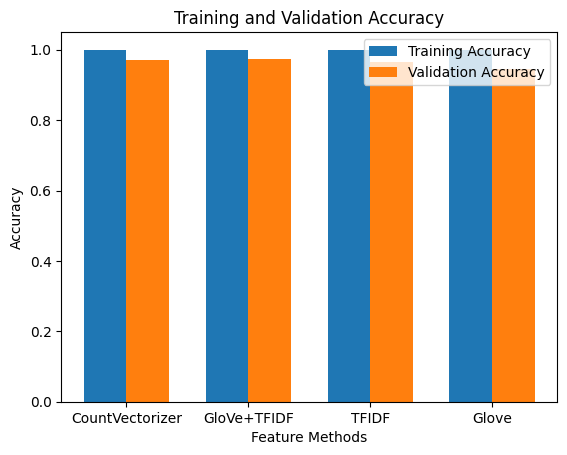

In [20]:
import matplotlib.pyplot as plt

# Define the data
methods = ['CountVectorizer', 'GloVe+TFIDF','TFIDF','Glove']
train_accuracies = [mean_train_accuracy_count, mean_train_accuracy_combined,mean_train_accuracy_tfidf,mean_train_accuracy_glove]
val_accuracies = [mean_val_accuracy_count,mean_val_accuracy_combined ,mean_val_accuracy_tfidf, mean_val_accuracy_glove]

# Set up positions for bars on x-axis
x = range(len(methods))

# Set bar width
bar_width = 0.35

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create bars for training accuracies
train_bars = plt.bar(x, train_accuracies, bar_width, label='Training Accuracy')

# Create bars for validation accuracies
val_bars = plt.bar([i + bar_width for i in x], val_accuracies, bar_width, label='Validation Accuracy')

# Set labels and title
plt.xlabel('Feature Methods')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks([i + bar_width/2 for i in x], methods)

# Add a legend
plt.legend()

# Show the plot
plt.show()


**The training and Validation accuracies are almost similar in both the cases.**





**Question 2:-**

2)b)

**5-fold cross-validation to evaluate the performance w.r.t. the learning rates ()**

In [21]:
import pandas as pd

# Define candidate learning rates
learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

# Initialize lists to store results
results = []

for lr in learning_rates:
    # Initialize the MLP Classifier with the specified learning rate
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=4000, learning_rate_init=lr, random_state=42)


    # Initialize variables to store accuracies
    train_accuracies = []
    val_accuracies = []

    # Perform 5-fold cross-validation manually
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_combined):
        X_train, X_val = X_combined[train_index], X_combined[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit the MLP Classifier on the training data
        mlp_classifier.fit(X_train, y_train)

        # Calculate the accuracy on the training set
        train_accuracy = mlp_classifier.score(X_train, y_train)
        train_accuracies.append(train_accuracy)

        # Calculate the accuracy on the validation set
        val_accuracy = mlp_classifier.score(X_val, y_val)
        val_accuracies.append(val_accuracy)

    # Calculate and store the mean and standard deviation of accuracies
    mean_train_accuracy = np.mean(train_accuracies)
    std_train_accuracy = np.std(train_accuracies)
    mean_val_accuracy = np.mean(val_accuracies)
    std_val_accuracy = np.std(val_accuracies)

    # Append results to the list
    results.append([lr, mean_train_accuracy, std_train_accuracy, mean_val_accuracy, std_val_accuracy])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Learning Rate', 'Avg Training Accuracy', 'Std Training Accuracy', 'Avg Validation Accuracy', 'Std Validation Accuracy'])


**2)b)1)**

****Report the average training and validation accuracy, and their standard deviation for different parameter values****

In [22]:
# Print the results

results_df

,Learning Rate,Avg Training Accuracy,Std Training Accuracy,Avg Validation Accuracy,Std Validation Accuracy
0,0.0001,1.0,0.0,0.974599,0.003765
1,0.0003,1.0,0.0,0.973660,0.004786
2,0.0010,1.0,0.0,0.972712,0.006274
3,0.0030,1.0,0.0,0.971769,0.005995
4,0.0100,1.0,0.0,0.974581,0.009736
5,0.0300,1.0,0.0,0.967074,0.007856
6,0.1000,1.0,0.0,0.965174,0.009763


In [23]:
for idx, (lr, train_accuracy, val_accuracy) in enumerate(zip(learning_rates, train_accuracies, val_accuracies)):
    print(f'Learning Rate: {lr}')
    print(f'Training Accuracy = {train_accuracy:.4f}, Validation Accuracy = {val_accuracy:.4f}')


Learning Rate: 0.0001
Training Accuracy = 1.0000, Validation Accuracy = 0.9718
Learning Rate: 0.0003
Training Accuracy = 1.0000, Validation Accuracy = 0.9671
Learning Rate: 0.001
Training Accuracy = 1.0000, Validation Accuracy = 0.9765
Learning Rate: 0.003
Training Accuracy = 1.0000, Validation Accuracy = 0.9481
Learning Rate: 0.01
Training Accuracy = 1.0000, Validation Accuracy = 0.9623


**Report the average training and validation accuracy, and their standard deviation for different parameter values**

In [24]:
# Calculate and store the mean and standard deviation of accuracies
mean_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
mean_val_accuracy = np.mean(val_accuracies)
std_val_accuracy = np.std(val_accuracies)

# Append results to the list
results.append([lr, mean_train_accuracy, std_train_accuracy, mean_val_accuracy, std_val_accuracy])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Learning Rate', 'Avg Training Accuracy', 'Std Training Accuracy', 'Avg Validation Accuracy', 'Std Validation Accuracy'])

# Print the results
results_df

,Learning Rate,Avg Training Accuracy,Std Training Accuracy,Avg Validation Accuracy,Std Validation Accuracy
0,0.0001,1.0,0.0,0.974599,0.003765
1,0.0003,1.0,0.0,0.973660,0.004786
2,0.0010,1.0,0.0,0.972712,0.006274
3,0.0030,1.0,0.0,0.971769,0.005995
4,0.0100,1.0,0.0,0.974581,0.009736
5,0.0300,1.0,0.0,0.967074,0.007856
6,0.1000,1.0,0.0,0.965174,0.009763
7,0.0100,1.0,0.0,0.965174,0.009763


**2)b)2)**

**Draw a line figure showing the training and validation result**

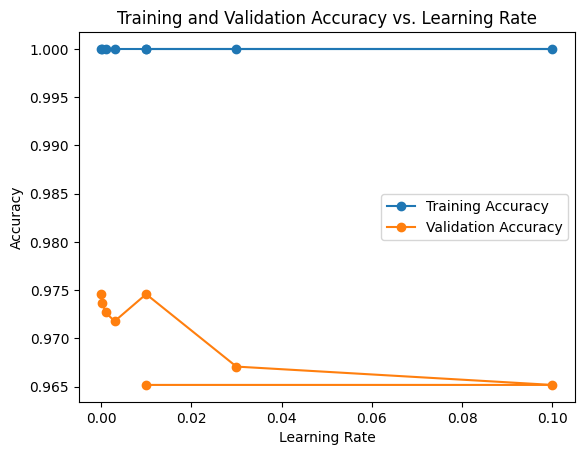

In [25]:
import matplotlib.pyplot as plt

# Extract parameter values and accuracies from the results DataFrame
learning_rates = results_df['Learning Rate']
train_accuracies = results_df['Avg Training Accuracy']
val_accuracies = results_df['Avg Validation Accuracy']

# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot training accuracies
ax.plot(learning_rates, train_accuracies, label='Training Accuracy', marker='o')

# Plot validation accuracies
ax.plot(learning_rates, val_accuracies, label='Validation Accuracy', marker='o')

# Set labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Learning Rate')

# Add a legend
plt.legend()

# Show the plot
plt.show()


**Question :- 2)c)**

**5-fold cross-validation to evaluate the performance w.r.t. optimizers, you could use the feature engineering method**

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Define a simple neural network
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

X_text = train['Unigrams'].apply(lambda x: ' '.join(x))  # Convert lists of words to space-separated strings
y = train['Category']

# Convert text data to a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_text)

# Initialize lists to store results
results = []

# Define candidate optimizers
optimizers = ['SGD', 'Adam', 'RMSprop']

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
    X_val = torch.tensor(X_val.toarray(), dtype=torch.float32)

    # Encode categorical labels
    label_encoder = LabelEncoder()
    y_train = torch.tensor(label_encoder.fit_transform(y_train), dtype=torch.long)
    y_val = torch.tensor(label_encoder.transform(y_val), dtype=torch.long)

    # Define input and output dimensions based on your data
    input_dim = X_train.shape[1]
    output_dim = len(label_encoder.classes_)

    for optimizer_name in optimizers:
        # Initialize the neural network and optimizer
        net = Net(input_dim, output_dim)
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(net.parameters(), lr=0.01)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(net.parameters(), lr=0.001)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(net.parameters(), lr=0.001)
        else:
            raise ValueError(f'Unsupported optimizer: {optimizer_name}')

        # Train the model
        criterion = nn.CrossEntropyLoss()
        for epoch in range(10):
            optimizer.zero_grad()
            outputs = net(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Calculate the accuracy on the training set
        train_accuracy = (net(X_train).argmax(dim=1) == y_train).float().mean().item()

        # Calculate the accuracy on the validation set
        val_accuracy = (net(X_val).argmax(dim=1) == y_val).float().mean().item()

        # Store the results
        results.append([optimizer_name, train_accuracy, val_accuracy])


In [27]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Optimizer', 'Training Accuracy', 'Validation Accuracy'])

# Print the results
results_df

,Optimizer,Training Accuracy,Validation Accuracy
0,SGD,0.897647,0.906103
1,Adam,0.997647,0.962441
2,RMSprop,1.000000,0.967136
3,SGD,0.877647,0.802817
4,Adam,0.996471,0.962441
5,RMSprop,1.000000,0.962441
6,SGD,0.891765,0.882629
7,Adam,0.998824,0.971831
8,RMSprop,1.000000,0.976526
9,SGD,0.888367,0.872642


**2)c)1)**

**Report the average training and validation accuracy, and their standard deviation for different parameter values**

In [28]:
import pandas as pd
results_df = pd.DataFrame(results, columns=['Optimizer', 'Training Accuracy', 'Validation Accuracy'])

# Calculate mean and standard deviation
mean_results = results_df.groupby('Optimizer').mean()
std_results = results_df.groupby('Optimizer').std()

print("Mean Results:")
mean_results



Mean Results:


,Training Accuracy,Validation Accuracy
Optimizer,,
Adam,0.997178,0.962362
RMSprop,1.000000,0.968013
SGD,0.889934,0.855102


In [29]:
print("\nStandard Deviation:")
std_results


Standard Deviation:


,Training Accuracy,Validation Accuracy
Optimizer,,
Adam,0.001051,0.006718
RMSprop,0.000000,0.006142
SGD,0.007662,0.045599


**2)c)2)**

**Draw a bar figure showing the training and validation result, x-axis should be the parameter values, y-axis should be the training and validation accuracy.**

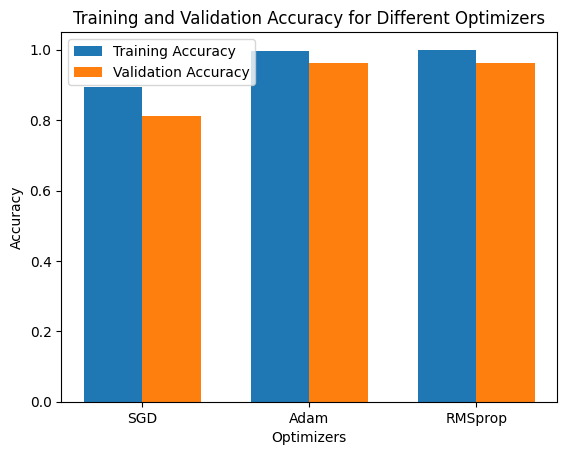

In [30]:
import matplotlib.pyplot as plt
# results (list of [optimizer_name, train_accuracy, val_accuracy] lists)

# Separate the results for each optimizer
sgd_results = [result for result in results if result[0] == 'SGD']
adam_results = [result for result in results if result[0] == 'Adam']
rmsprop_results = [result for result in results if result[0] == 'RMSprop']

# Extract the accuracies
sgd_train_accuracies = [result[1] for result in sgd_results]
sgd_val_accuracies = [result[2] for result in sgd_results]

adam_train_accuracies = [result[1] for result in adam_results]
adam_val_accuracies = [result[2] for result in adam_results]

rmsprop_train_accuracies = [result[1] for result in rmsprop_results]
rmsprop_val_accuracies = [result[2] for result in rmsprop_results]

# Define labels and positions
labels = ['SGD', 'Adam', 'RMSprop']
x = range(len(labels))

# Set bar width
bar_width = 0.35

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create bars for training accuracies
train_bars = plt.bar(x, [sgd_train_accuracies[-1], adam_train_accuracies[-1], rmsprop_train_accuracies[-1]], bar_width, label='Training Accuracy')

# Create bars for validation accuracies
val_bars = plt.bar([i + bar_width for i in x], [sgd_val_accuracies[-1], adam_val_accuracies[-1], rmsprop_val_accuracies[-1]], bar_width, label='Validation Accuracy')

# Set labels and title
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Different Optimizers')
plt.xticks([i + bar_width/2 for i in x], labels)

# Add a legend
plt.legend()

# Show the plot
plt.show()


**Question 3:-**

**Predict the labels for the testing data**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the MLP Classifier with Adam optimizer and learning rate of 0.0001
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', solver='adam', learning_rate_init=0.0001, max_iter=1000)

# Pre-process the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train['Unigrams'].apply(lambda x: ' '.join(x)))

def sentence_to_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_model[word] for word in words if word in glove_model]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)

X_train_glove = np.array([sentence_to_embedding(' '.join(sentence)) for sentence in train['Unigrams']])
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_glove))
X_train_torch = torch.tensor(X_train_combined, dtype=torch.float32)

# Fit the MLP Classifier with training data
mlp_classifier.fit(X_train_combined, train['Category'])

# Pre-process the test data
X_test_tfidf = tfidf_vectorizer.transform(test['Unigrams'].apply(lambda x: ' '.join(x)))

X_test_glove = np.array([sentence_to_embedding(' '.join(sentence)) for sentence in test['Unigrams']])
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_glove))
X_test_torch = torch.tensor(X_test_combined, dtype=torch.float32)

# Predict labels for the test data using the trained MLP Classifier
test_predictions = mlp_classifier.predict(X_test_combined)

# Add the 'Predicted Category' column to the 'test' DataFrame
test['Predicted Category'] = test_predictions

# Print the updated DataFrame with predicted categories
test


,ArticleId,Text,Unigrams,Bigrams,Predicted Category
0,1018,qpr keeper day heads for preston queens park r...,"[qpr, keeper, day, head, preston, queen, park,...","[qpr keeper, keeper day, day head, head presto...",sport
1,1319,software watching while you work software that...,"[softwar, watch, work, softwar, monitor, everi...","[softwar watch, watch work, work softwar, soft...",tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,"[arci, injuri, add, ireland, woe, gordon, arci...","[arci injuri, injuri add, add ireland, ireland...",sport
3,459,india s reliance family feud heats up the ongo...,"[india, relianc, famili, feud, heat, ongo, pub...","[india relianc, relianc famili, famili feud, f...",business
4,1020,boro suffer morrison injury blow middlesbrough...,"[boro, suffer, morrison, injuri, blow, middles...","[boro suffer, suffer morrison, morrison injuri...",sport
...,...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,"[eu, probe, alitalia, state, aid, european, co...","[eu probe, probe alitalia, alitalia state, sta...",business
731,373,u2 to play at grammy awards show irish rock ba...,"[u2, play, grammi, award, show, irish, rock, b...","[u2 play, play grammi, grammi award, award sho...",entertainment
732,1704,sport betting rules in spotlight a group of mp...,"[sport, bet, rule, spotlight, group, mp, peer,...","[sport bet, bet rule, rule spotlight, spotligh...",tech
733,206,alfa romeos to get gm engines fiat is to sto...,"[alfa, romeo, get, gm, engin, fiat, stop, make...","[alfa romeo, romeo get, get gm, gm engin, engi...",business


In [32]:

# Save the DataFrame as a CSV file without header and with specific columns
test[['ArticleId', 'Predicted Category']].to_csv('labels.csv', index=False, header=False)


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np

# Define the MLP Classifier with RMSprop optimizer and learning rate of 0.0001
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', solver='adam', learning_rate_init=0.0001, max_iter=1000)

# Pre-process the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train['Unigrams'].apply(lambda x: ' '.join(x)))

def sentence_to_embedding(sentence):
    words = sentence.split()
    embeddings = [glove_model[word] for word in words if word in glove_model]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)

X_train_glove = np.array([sentence_to_embedding(' '.join(sentence)) for sentence in train['Unigrams']])
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_glove))
X_train_torch = torch.tensor(X_train_combined, dtype=torch.float32)

# Fit the MLP Classifier with training data
mlp_classifier.fit(X_train_combined, train['Category'])

# Predict labels for the training data using the trained MLP Classifier
train_predictions = mlp_classifier.predict(X_train_combined)

# Calculate the accuracy of training predictions compared to training labels
train_accuracy = accuracy_score(train['Category'], train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Add the 'Predicted Category' column to the 'train' DataFrame
train['Predicted Category'] = train_predictions

# Print the updated DataFrame with predicted categories
train


Training Accuracy: 1.00


,ArticleId,Text,Category,Unigrams,Bigrams,Predicted Category
0,893,rangers seal old firm win goals from gregory v...,sport,"[ranger, seal, old, firm, win, goal, gregori, ...","[ranger seal, seal old, old firm, firm win, wi...",sport
1,1164,bt program to beat dialler scams bt is introdu...,tech,"[bt, program, beat, dialler, scam, bt, introdu...","[bt program, program beat, beat dialler, diall...",tech
2,1696,new yob targets to be unveiled fifty new are...,politics,"[new, yob, target, unveil, fifti, new, area, g...","[new yob, yob target, target unveil, unveil fi...",politics
3,396,holmes is hit by hamstring injury kelly holmes...,sport,"[holm, hit, hamstr, injuri, kelli, holm, forc,...","[holm hit, hit hamstr, hamstr injuri, injuri k...",sport
4,1862,capriati out of australian open jennifer capri...,sport,"[capriati, australian, open, jennif, capriati,...","[capriati australian, australian open, open je...",sport
...,...,...,...,...,...,...
1058,101,housewives lift channel 4 ratings the debut of...,entertainment,"[housew, lift, channel, 4, rate, debut, us, te...","[housew lift, lift channel, channel 4, 4 rate,...",entertainment
1059,1369,no uk apology for colonial past the days of b...,politics,"[uk, apolog, coloni, past, day, britain, apolo...","[uk apolog, apolog coloni, coloni past, past d...",politics
1060,2221,cars pull down us retail figures us retail sal...,business,"[car, pull, us, retail, figur, us, retail, sal...","[car pull, pull us, us retail, retail figur, f...",business
1061,916,highbury tunnel players in clear the football ...,sport,"[highburi, tunnel, player, clear, footbal, ass...","[highburi tunnel, tunnel player, player clear,...",sport
